In [1]:
import pylsl
import time
from random import random as rand
import numpy as np
import matplotlib.pyplot as plt

0.10746502416303413
3.6215209365379787e-13


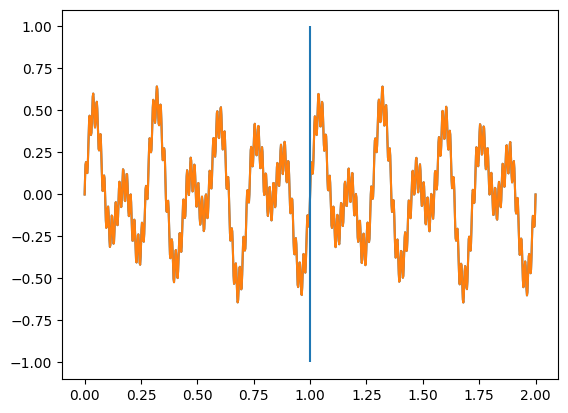

In [91]:
t = np.linspace(0, 2, 1000)

factor_4 = 0.25
factor_7 = 0.3
factor_60 = 0.1

sine = lambda data: np.sin(2.0 * np.pi * data[0]*(t))
phase = 0
phase2 = 1
ch1 = factor_4*sine([4, phase]) + factor_7*sine([7, phase]) + factor_60*sine([60, phase])
ch2 = factor_4*sine([4, phase2]) + factor_7*sine([7, phase2]) + factor_60*sine([60, phase2])
print(ch1[1])
print(ch2[0])

plt.plot(t, ch1)
plt.plot(t, ch2)
plt.vlines(1, -1, 1)

In [10]:
name = 'LSLExample'
srate = 32
stream_type = 'EEG'
channel_names = ["Fp1", "Fp2"]
n_channels = len(channel_names)

info = pylsl.StreamInfo(name, stream_type, n_channels, srate, 'float32', 'myuid2424')

# info.desc().append_child_value("manufacturer", "LSLExampleAmp")
# chns = info.desc().append_child("channels")
# for chan_ix, label in enumerate(channel_names):
#     ch = chns.append_child("channel")
#     ch.append_child_value("label", label)
#     ch.append_child_value("unit", "microvolts")
#     ch.append_child_value("type", "EEG")
#     ch.append_child_value("scaling_factor", "1")
#     loc = ch.append_child("location")

outlet = pylsl.StreamOutlet(info, 32, 320)
print("now sending data...")
start_time = pylsl.local_clock()
sent_samples = 0
while True:
    elapsed_time = pylsl.local_clock() - start_time
    required_samples = int(srate * elapsed_time) - sent_samples
    if required_samples > 0:
        []
        # Generate data
        # mychunk = [[rand() for chan_ix in range(n_channels)]
        #             for samp_ix in range(required_samples)]
        # Get a time stamp in seconds. We pretend that our samples are actually
        # 125ms old, e.g., as if coming from some external hardware with known latency.
        stamp = pylsl.local_clock() - 0.125
        # now send it and wait for a bit
        # Note that even though `rand()` returns a 64-bit value, the `push_chunk` method
        #  will convert it to c_float before passing the data to liblsl.
        outlet.push_chunk(mychunk, stamp)
        sent_samples += required_samples
    time.sleep(0.02)

2023-04-05 20:01:18.569 (1239.017s) [python          ]         udp_server.cpp:81    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fdc3:6f7d:1e74:4c95:f2e5:4f17:321d:ae52 (Address already in use)
2023-04-05 20:01:18.569 (1239.017s) [python          ]         udp_server.cpp:81    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2607:f010:2a7:1003:4680:cb86:7c4f:6082 (Address already in use)
2023-04-05 20:01:18.569 (1239.017s) [python          ]         udp_server.cpp:81    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface 2607:f010:2a7:1003:d6e8:46d:e4ca:a221 (Address already in use)
2023-04-05 20:01:18.569 (1239.017s) [python          ]         udp_server.cpp:81    WARN| Could not bind multicast responder for ff02:113d:6fdd:2c17:a643:ffe2:1bd1:3cd2 to interface fe80::364a:1f8b:8dcd:822d%wlp0s20f3 (Address already in use)
2023-04-05 20:01:18

now sending data...


KeyboardInterrupt: 